# HW1: Fuel Performance -> Horsepower

**Dataset:** FuelEconomy.csv

**Name:** Eric Liu

**Resources Consulted:** Regression Case Study: Student Performance

In [2]:

# ============================================================
# Imports
# ============================================================

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import matplotlib.pyplot as plt


# Loading Dataset

This section loads the given dataset into a pandas DataFrame, and lists out the characteristics of the data, including the key metrics and missing data.

In [ ]:
DATA_PATH = "FuelEconomy.csv"
df = pd.read_csv(DATA_PATH)

print("Shape:", df.shape)
print("\nColumns:")
print(df.columns.tolist())

print("\nSummary statistics:")
display(df.describe(include="all"))

print("\nMissing values per column:")
display(df.isna().sum())

Shape: (100, 2)

Columns:
['Horse Power', 'Fuel Economy (MPG)']

Summary statistics:


,Horse Power,Fuel Economy (MPG)
count,100.000000,100.000000
mean,213.676190,23.178501
std,62.061726,4.701666
min,50.000000,10.000000
25%,174.996514,20.439516
50%,218.928402,23.143192
75%,251.706476,26.089933
max,350.000000,35.000000



Missing values per column:


Horse Power           0
Fuel Economy (MPG)    0
dtype: int64

# Utility Functions

Functions to prepare data and run model. Functions are reused from the Regression Case Study demo.

In [ ]:
TARGET_COL = "Horse Power"

def prepare_xy(df_in, target_col=TARGET_COL):
    """Drop missing rows, split into X and y."""
    df_clean = df_in.dropna().copy()
    X = df_clean.drop(columns=[target_col])
    y = df_clean[target_col]
    return X, y

def split_data(X, y, test_size=0.30, random_state=42):
    """70/30 random train-test split."""
    return train_test_split(X, y, test_size=test_size, random_state=random_state)

def compute_metrics(y_true, y_pred):
    """Return MSE, MAE, R^2."""
    return {
        "MSE": mean_squared_error(y_true, y_pred),
        "MAE": mean_absolute_error(y_true, y_pred),
        "R^2": r2_score(y_true, y_pred),
    }

def _get_linear_parts(model, input_feature_names):
    """Extract (intercept, coefficients, feature_names) from either:
       - LinearRegression
       - Pipeline(PolynomialFeatures -> LinearRegression)
    """
    # Plain LinearRegression
    if isinstance(model, LinearRegression):
        intercept = float(model.intercept_)
        coefs = np.array(model.coef_).ravel()
        feat_names = np.array(list(input_feature_names))
        return intercept, coefs, feat_names

    # Polynomial pipeline
    if hasattr(model, "named_steps") and "poly" in model.named_steps and "lr" in model.named_steps:
        poly = model.named_steps["poly"]
        lr = model.named_steps["lr"]

        feat_names = poly.get_feature_names_out(input_features=list(input_feature_names))
        intercept = float(lr.intercept_)
        coefs = np.array(lr.coef_).ravel()
        return intercept, coefs, np.array(feat_names)

    raise ValueError("Unsupported model type for equation printing.")

def print_fitted_equation(model, input_feature_names, target_name=TARGET_COL, top_k_terms=15):
    """Print a readable fitted equation.

    For polynomial models, the number of terms can become very large,
    so we print only the TOP-K terms by absolute coefficient magnitude.
    """
    intercept, coefs, feat_names = _get_linear_parts(model, input_feature_names)

    # Sort by absolute coefficient magnitude
    order = np.argsort(np.abs(coefs))[::-1]
    order = order[:min(top_k_terms, len(coefs))]

    terms = []
    for idx in order:
        terms.append(f"({coefs[idx]:+.4f}) * {feat_names[idx]}")

    eq = f"{target_name} = {intercept:.4f} " + " ".join(terms)

    print("\n--- Fitted Model Equation (Top Terms) ---")
    print(eq)
    if len(coefs) > top_k_terms:
        print(f"(Showing top {top_k_terms} terms out of {len(coefs)} total terms.)")

def plot_actual_vs_predicted_test(y_test, y_pred, title, max_points=300):
    """Scatter plot of Actual vs Predicted values on the TEST set.

    We plot both series against a sample index, using:
    - Actual: blue circles
    - Predicted: red x's

    If test set is large, we randomly sample up to max_points points for readability.
    """
    y_test = np.array(y_test)
    y_pred = np.array(y_pred)

    n = len(y_test)
    if n > max_points:
        rng = np.random.default_rng(0)
        sel = rng.choice(n, size=max_points, replace=False)
        y_test = y_test[sel]
        y_pred = y_pred[sel]

    x = np.arange(len(y_test))

    plt.figure(figsize=(12, 4))
    plt.scatter(x, y_test, marker="o", alpha=0.8, label="Actual (Test)")
    plt.scatter(x, y_pred, marker="x", alpha=0.8, label="Predicted (Test)")
    plt.title(title)
    plt.xlabel("Test sample index (subset)")
    plt.ylabel(TARGET_COL)
    plt.grid(True, linestyle="--", alpha=0.4)
    plt.legend()
    plt.show()

def run_models_and_evaluate(df_in, scenario_name, degrees=(1, 2, 3, 4),
                            target_col=TARGET_COL, test_size=0.30, random_state=42,
                            show_equation=True, show_plots=True, top_k_terms=15):
    """Train/evaluate linear (deg=1) + polynomial regression models.

    Returns a DataFrame of metrics.
    Also prints fitted equations and scatter plots (test set) for each model.
    """
    X, y = prepare_xy(df_in, target_col=target_col)
    X_train, X_test, y_train, y_test = split_data(X, y, test_size=test_size, random_state=random_state)

    rows = []

    for deg in degrees:
        if deg == 1:
            model = LinearRegression()
            model_name = "Linear Regression"
        else:
            model = Pipeline([
                ("poly", PolynomialFeatures(degree=deg, include_bias=False)),
                ("lr", LinearRegression())
            ])
            model_name = f"Polynomial Regression (degree={deg})"

        # Fit model
        model.fit(X_train, y_train)

        # Predict
        yhat_train = model.predict(X_train)
        yhat_test  = model.predict(X_test)

        # Metrics
        train_m = compute_metrics(y_train, yhat_train)
        test_m  = compute_metrics(y_test, yhat_test)

        # Report equation + plot (TEST set)
        print("\n============================================================")
        print(f"Scenario: {scenario_name}")
        print(f"Model: {model_name}")
        print("============================================================")

        if show_equation:
            print_fitted_equation(
                model=model,
                input_feature_names=X_train.columns,
                target_name=target_col,
                top_k_terms=top_k_terms
            )

        if show_plots:
            plot_actual_vs_predicted_test(
                y_test=y_test,
                y_pred=yhat_test,
                title=f"{scenario_name} — {model_name} (Test Set: Actual vs Predicted)"
            )

        rows.append({
            "Scenario": scenario_name,
            "Model": model_name,
            "Train MSE": train_m["MSE"],
            "Train MAE": train_m["MAE"],
            "Train R^2": train_m["R^2"],
            "Test MSE": test_m["MSE"],
            "Test MAE": test_m["MAE"],
            "Test R^2": test_m["R^2"],
            "Train size": len(X_train),
            "Test size": len(X_test),
        })

    return pd.DataFrame(rows)


# Execution

Runs models and displays resultant actual vs. predicted results for each regression degree, and displays a table showing test and train metrics.


Scenario: Fuel Performance vs, HP
Model: Linear Regression

--- Fitted Model Equation (Top Terms) ---
Horse Power = 500.3638 (-12.3785) * Fuel Economy (MPG)


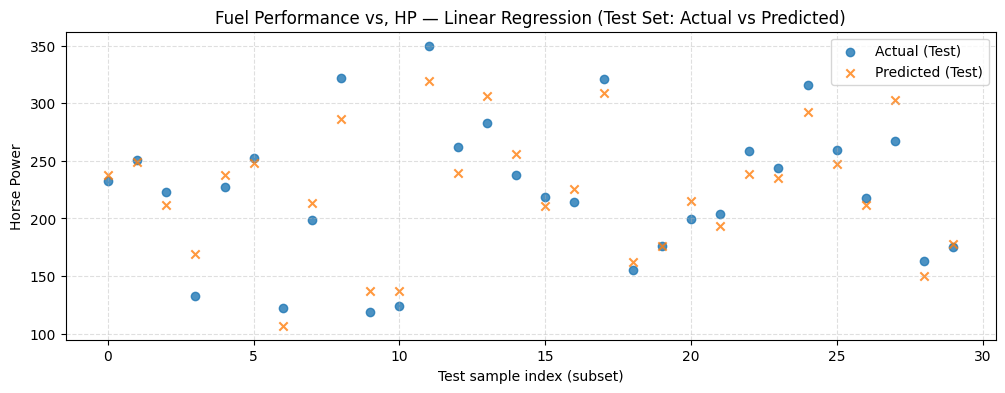


Scenario: Fuel Performance vs, HP
Model: Polynomial Regression (degree=2)

--- Fitted Model Equation (Top Terms) ---
Horse Power = 457.3741 (-8.5915) * Fuel Economy (MPG) (-0.0800) * Fuel Economy (MPG)^2


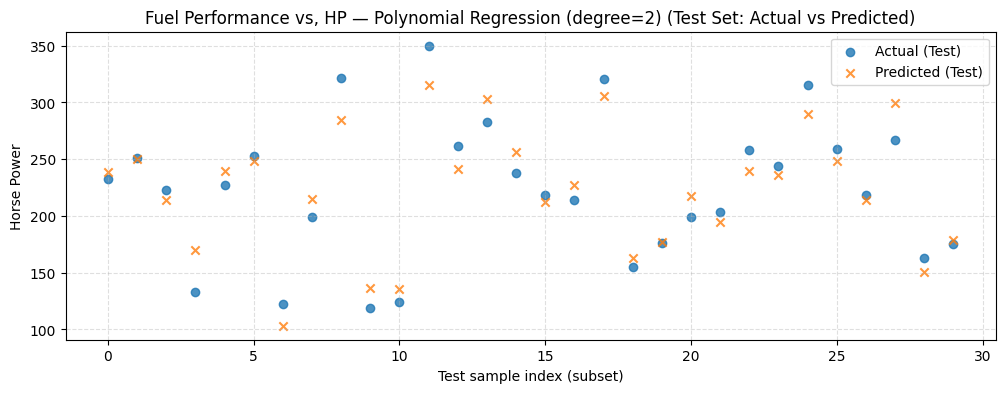


Scenario: Fuel Performance vs, HP
Model: Polynomial Regression (degree=3)

--- Fitted Model Equation (Top Terms) ---
Horse Power = 355.6514 (+6.0952) * Fuel Economy (MPG) (-0.7505) * Fuel Economy (MPG)^2 (+0.0097) * Fuel Economy (MPG)^3


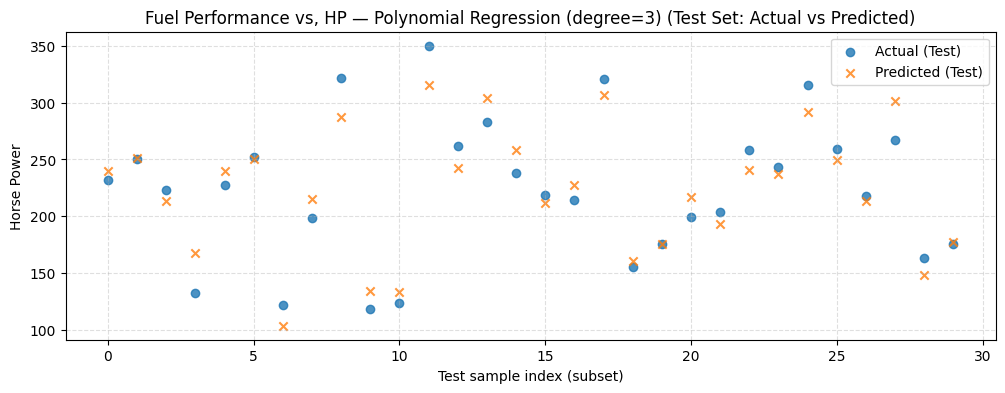


Scenario: Fuel Performance vs, HP
Model: Polynomial Regression (degree=4)

--- Fitted Model Equation (Top Terms) ---
Horse Power = 90.1049 (+61.1736) * Fuel Economy (MPG) (-4.7743) * Fuel Economy (MPG)^2 (+0.1339) * Fuel Economy (MPG)^3 (-0.0014) * Fuel Economy (MPG)^4


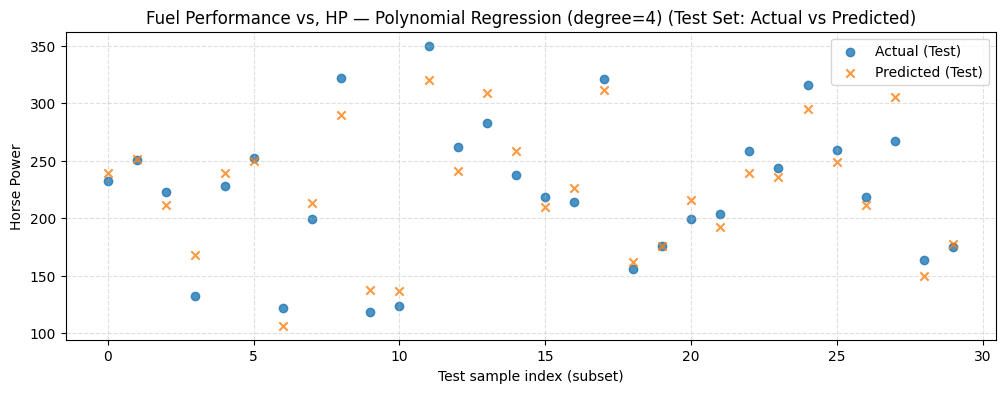

,Scenario,Model,Train MSE,Train MAE,Train R^2,Test MSE,Test MAE,Test R^2,Train size,Test size
0,"Fuel Performance vs, HP",Linear Regression,357.699180,16.061689,0.906320,318.561087,14.940628,0.912561,70,30
1,"Fuel Performance vs, HP",Polynomial Regression (degree=2),350.879731,15.995824,0.908106,331.105434,15.148330,0.909118,70,30
2,"Fuel Performance vs, HP",Polynomial Regression (degree=3),345.108668,15.746762,0.909618,318.404012,14.764973,0.912604,70,30
3,"Fuel Performance vs, HP",Polynomial Regression (degree=4),339.700171,15.508465,0.911034,313.798757,14.735471,0.913868,70,30


In [6]:
results = run_models_and_evaluate(
    df,
    scenario_name="Fuel Performance vs, HP",
    degrees=(1, 2, 3, 4),
    show_equation=True,
    show_plots=True,
    top_k_terms=15
)

display(results)